# Wine Reviews – Exploratory Analysis & Market Expectation Design

This notebook explores the Wine Reviews dataset to understand market perception patterns and to define the modeling strategy for predicting expected consumer ratings.

The goal is not to clean or model aggressively at this stage, but to:
- Validate the dataset structure
- Explore rating and price behavior
- Make explicit, documented decisions for the market expectation model


## 1. Setup and configuration

We load the project configuration and define paths to ensure reproducibility and avoid hard-coded file locations.


In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
REVIEWS_FILE = config["files"]["wine_reviews"]


## 2. Data loading

The Wine Reviews dataset is loaded as the primary source for market perception, including ratings, prices, and categorical descriptors such as country and variety.


In [2]:
wine_reviews = pd.read_csv(RAW_PATH / REVIEWS_FILE)

wine_reviews.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## 3. Initial sanity checks

Before any analysis, we inspect the dataset shape, data types, and missing values to assess overall data quality and suitability for modeling.


In [3]:
wine_reviews.shape




(129971, 14)

In [4]:
wine_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [5]:
wine_reviews.isna().sum().sort_values(ascending=False).head(15)

region_2                 79460
designation              37465
taster_twitter_handle    31213
taster_name              26244
region_1                 21247
price                     8996
country                     63
province                    63
variety                      1
Unnamed: 0                   0
description                  0
points                       0
title                        0
winery                       0
dtype: int64

In [6]:
wine_reviews.describe(include="all").T.head(10)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,129971.0,NaN,NaN,NaN,64985.0,37519.540256,0.0,32492.5,64985.0,97477.5,129970.0
country,129908,43,US,54504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,129971,119955,"Seductively tart in lemon pith, cranberry and ...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,92506,37979,Reserve,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,129971.0,NaN,NaN,NaN,88.447138,3.03973,80.0,86.0,88.0,91.0,100.0
price,120975.0,NaN,NaN,NaN,35.363389,41.022218,4.0,17.0,25.0,42.0,3300.0
province,129908,425,California,36247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,108724,1229,Napa Valley,4480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,50511,17,Central Coast,11065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_name,103727,19,Roger Voss,25514,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Column overview and preliminary selection

At this stage, we review available columns and identify:
- Potential target variables
- Candidate features
- Fields likely to be excluded due to sparsity or complexity


In [7]:
wine_reviews.columns


Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [8]:
wine_reviews["points"].describe()


count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [9]:
wine_reviews["price"].describe()



count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

<Axes: >

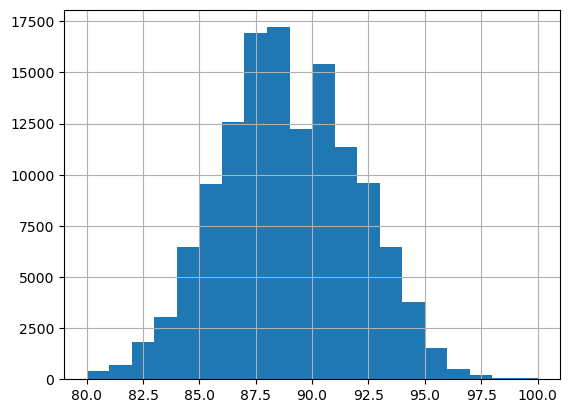

In [10]:
wine_reviews["points"].hist(bins=20)


<Axes: >

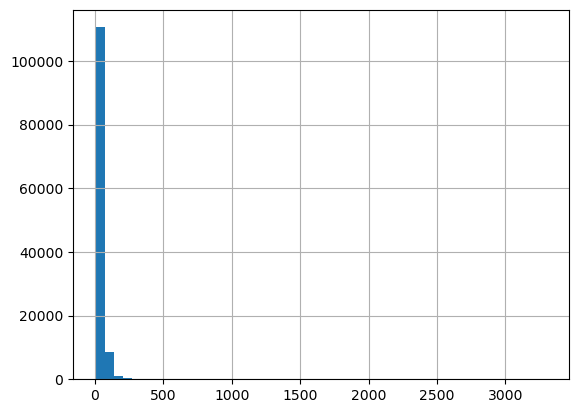

In [11]:
wine_reviews["price"].hist(bins=50)


## 5. Removal of highly sparse regional fields

The fields `region_1` and `region_2` contain a large proportion of missing values and introduce high geographical granularity.  
They are removed to reduce noise and improve model interpretability.


In [12]:
cols_to_drop = ["region_1", "region_2"]
wine_reviews_eda = wine_reviews.drop(columns=cols_to_drop)

wine_reviews_eda.shape


(129971, 12)

## 6. Target analysis: consumer ratings (`points`)

Consumer ratings (`points`) are analyzed to assess their stability, distribution, and suitability as the target variable for market expectation modeling.


In [13]:
wine_reviews_eda["points"].describe()


count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [14]:
wine_reviews_eda["points"].value_counts().sort_index()


points
80       397
81       692
82      1836
83      3025
84      6480
85      9530
86     12600
87     16933
88     17207
89     12226
90     15410
91     11359
92      9613
93      6489
94      3758
95      1535
96       523
97       229
98        77
99        33
100       19
Name: count, dtype: int64

<Axes: >

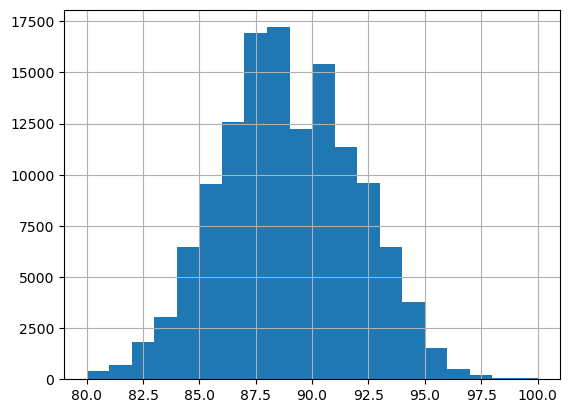

In [15]:
wine_reviews_eda["points"].hist(bins=20)


## 7. Price exploration and relationship with ratings

Price is explored as a potential explanatory variable rather than a target, due to skewness and missing values.
We analyze its distribution and relationship with consumer ratings.


In [16]:
wine_reviews_eda["price"].describe()


count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

In [17]:
wine_reviews_eda[["points", "price"]].dropna().corr()


,points,price
points,1.000000,0.416167
price,0.416167,1.000000


<Axes: xlabel='price', ylabel='points'>

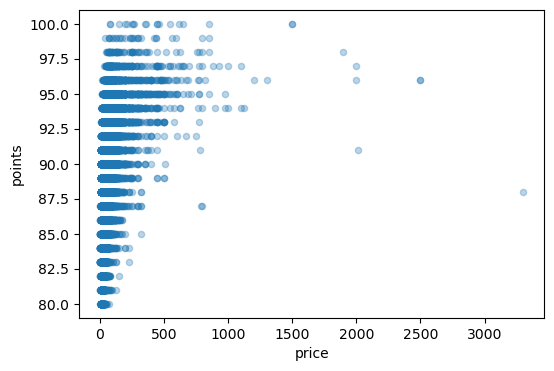

In [18]:
wine_reviews_eda.plot.scatter(
    x="price",
    y="points",
    alpha=0.3,
    figsize=(6, 4)
)


## 8. Log transformation of price

Due to the heavy right-skew in the price distribution, a log transformation is applied.
This transformed variable will be used selectively in one of the market expectation models.


In [19]:
wine_reviews_eda["log_price"] = np.log(wine_reviews_eda["price"])
wine_reviews_eda["log_price"].describe()


count    120975.000000
mean          3.314636
std           0.654040
min           1.386294
25%           2.833213
50%           3.218876
75%           3.737670
max           8.101678
Name: log_price, dtype: float64

## 9. Categorical signal overview

We inspect the most frequent countries and grape varieties to guide feature selection and avoid high-cardinality issues during modeling.


In [20]:
wine_reviews_eda["country"].value_counts().head(10)


country
US           54504
France       22093
Italy        19540
Spain         6645
Portugal      5691
Chile         4472
Argentina     3800
Austria       3345
Australia     2329
Germany       2165
Name: count, dtype: int64

In [21]:
wine_reviews_eda["variety"].value_counts().head(10)


variety
Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
Rosé                         3564
Merlot                       3102
Name: count, dtype: int64

## 10. Market expectation model design decisions

Based on the exploratory analysis above, the following modeling strategy is defined:

- Target variable: `points`
- Two model variants will be developed:
  - **Model 2A**: baseline market expectation model excluding price
  - **Model 2B**: extended model including log-transformed price
- Price will not be used as a target due to skewness and missing values
- Rows with missing price will only be excluded in Model 2B
- Highly sparse regional fields were removed to reduce noise and improve interpretability

These decisions lock the scope for the market perception modeling phase.
